In [333]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import plotly.express as px
from ipywidgets import interact, interact_manual
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from collections import namedtuple
import contextily as cx
import csv
import functools
import geopandas as gpd
import glob
from ipywidgets import interact
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
from numpy import genfromtxt

from osgeo import gdal
from osgeo import osr
import os
import pandas as pd
from pprint import pprint
from pulearn import BaggingPuClassifier
import rioxarray as rxr
from scipy import interp
import scipy.spatial
from scipy.spatial import distance_matrix
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import mapping
import shapely.strtree
from skimage import exposure, util
from skimage.feature import graycomatrix, graycoprops
from tqdm.notebook import tqdm

import sklearn
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, plot_roc_curve, roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

def interactive_hist(df, columns, colorby=None):
  """Plots interactive histograms of a dataframe. 
  Input:
    df: a pandas dataframe containing numerical columns
    columns: list of columns within dataframe
    colorby: column within dataframe to color data by
  Output:
    None
  Jack Maughan
  DATAROCK
  Date: 2/5/2022"""

  @interact(x=columns)
  def update(x):
      fig = px.histogram(df, x=x, nbins=100, color=colorby)
      fig.update_layout(xaxis = dict(title=x+' Values'), 
                      yaxis = dict(title='Counts'),
                      title = "Distribution Data - "+x, 
                      barmode='stack',    autosize=True,
                      width=800, height=600)
      fig.show('notebook')


# generate a confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    '''pretty print for confusion matrixes'''
    columnwidth = max([len(x) for x in labels]) + 4
    empty_cell = ' ' * columnwidth
    print('    ' + empty_cell, end=' ')
    for label in labels:
        print('%{0}s'.format(columnwidth) % 'pred_' + label, end=' ')
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print('    %{0}s'.format(columnwidth) % 'true_' + label1, end=' ')
        for j in range(len(labels)):
            cell = '%{0}.1f'.format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            if cell:
                print(cell, end=' ')
        print()


def plot_3D_scatter(df, columns, colorby=None):
    """Plots interactive 3D scatter plots of dataframes.Number of dataframes
    in the list 'dfs' determines how many scatters are plotted (max. 6).
    Input:
    dfs: a list of pandas dataframes containing numerical columns
    columns: list of columns within dataframe
    subplot_titles: list of titles for each plot
    colorby: array/pd.Series to colorby (numerical)
    Output:
    None
    Jack Maughan
    DATAROCK
    Date: 2/5/2022"""
    df0 = df[df['colour_label']==0]
    df1 = df[df['colour_label']==1]    
    df2 = df[df['colour_label']==2]

    @interact(x=columns, y=columns, z=columns)
    def update(x, y, z):
        fig = go.Figure()
        fig.add_trace(go.Scatter3d(x=df0[columns][x], y=df0[columns][y], z=df0[columns][z], name ='Background', marker=dict(color = '#EF553B', size=6, line=dict(width=2, color='DarkSlateGrey')), mode='markers'))
        fig.add_trace(go.Scatter3d(x=df1[columns][x], y=df1[columns][y], z=df1[columns][z], name = 'GAN Deposits', marker=dict(color = '#00CC96', size=6, line=dict(width=2, color='DarkSlateGrey')), mode='markers'))
        fig.add_trace(go.Scatter3d(x=df2[columns][x], y=df2[columns][y], z=df2[columns][z], name = 'Actual Deposits', marker=dict(color = '#636EFA', size=6, line=dict(width=2, color='DarkSlateGrey')), mode='markers'))

        
    
        #Update layout to include axis titles
        fig.update_layout(height=1200, width=1200, showlegend=True, scene1 = dict(xaxis_title=x, yaxis_title=y, zaxis_title=z))
        fig.show('notebook')

#### EDA

In [298]:
df = pd.read_csv('smote_gan_columns_Co.csv')
df.head(15)

,Ag_soil,Al_soil,As_soil,Au_soil,Ba_soil,Be_soil,Bi_soil,Ca_soil,Cd_soil,Ce_soil,...,"Neoproterozoic - Ordovician polygons_Slope to basinal shale, siltstone, lime mudstone; minor sandstone and pebbly sandstone at top",Neoproterozoic - Ordovician polygons_Syn-Delamerian mafic intrusive rocks,"Neoproterozoic - Ordovician polygons_Undifferentiated Cambro-Ordovician metasediments, including Kanmantoo Group?",Neoproterozoic - Ordovician polygons_Undifferentiated Neoproterozoic rocks,"Neoproterozoic - Ordovician polygons_Undifferentiated Neoproterozoic to Cambrian metasediments, Neoproterozoic-Ordovician volcanics and mafic intrusives",Neoproterozoic - Ordovician polygons_Undifferentiated Proterozoic rocks,"Neoproterozoic - Ordovician polygons_Volcaniclastics, porphyritic trachyte, dacite","Neoproterozoic - Ordovician polygons_Vuggy dolomite; shelf limestone, dolomite, siltstone, shale and sandstone; glauconitic sandstone","Neoproterozoic - Ordovician polygons_Within-plate amygdaloidal basalt, hyaloclastite, porphyritic and trachytic basalt",label
0,-0.148653,-0.205735,0.133028,-0.133012,-0.181980,0.078759,-0.199128,-0.117539,-0.083921,-0.306286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.505113,2.635810,-1.171303,-0.157419,1.122872,-2.105673,-0.408191,0.926316,-0.598847,2.835151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.351863,-0.205735,-1.886645,-0.156791,-0.181980,0.078759,-0.433241,-1.119143,-0.533638,2.312036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.551521,-0.205735,2.450703,-0.155771,-0.181980,0.078759,-0.585509,2.671770,-0.643158,-0.303559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.148653,-0.205735,0.133028,-0.133012,-0.181980,0.078759,-0.199128,-0.117539,-0.083921,-0.306286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,-0.547612,-0.205735,-2.567148,-0.164696,-0.181980,0.078759,-0.585514,-0.098316,-0.638918,-0.306286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,1.283715,-0.205735,-0.098663,-0.125802,-0.575243,0.078759,3.426216,2.660251,-0.559159,0.474302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,-0.148653,-0.205735,0.133028,-0.133012,-0.181980,0.078759,-0.199128,-0.117539,-0.083921,-0.306286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.148653,-0.205735,0.133028,-0.133012,-0.181980,0.078759,-0.199128,-0.117539,-0.083921,-0.306286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-0.148653,-0.205735,0.133028,-0.133012,-0.181980,0.078759,-0.199128,-0.117539,-0.083921,-0.306286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [299]:
df['colour_label'] = df['label']

df.loc[:7, 'colour_label']=2
df

,Ag_soil,Al_soil,As_soil,Au_soil,Ba_soil,Be_soil,Bi_soil,Ca_soil,Cd_soil,Ce_soil,...,Neoproterozoic - Ordovician polygons_Syn-Delamerian mafic intrusive rocks,"Neoproterozoic - Ordovician polygons_Undifferentiated Cambro-Ordovician metasediments, including Kanmantoo Group?",Neoproterozoic - Ordovician polygons_Undifferentiated Neoproterozoic rocks,"Neoproterozoic - Ordovician polygons_Undifferentiated Neoproterozoic to Cambrian metasediments, Neoproterozoic-Ordovician volcanics and mafic intrusives",Neoproterozoic - Ordovician polygons_Undifferentiated Proterozoic rocks,"Neoproterozoic - Ordovician polygons_Volcaniclastics, porphyritic trachyte, dacite","Neoproterozoic - Ordovician polygons_Vuggy dolomite; shelf limestone, dolomite, siltstone, shale and sandstone; glauconitic sandstone","Neoproterozoic - Ordovician polygons_Within-plate amygdaloidal basalt, hyaloclastite, porphyritic and trachytic basalt",label,colour_label
0,-0.148653,-0.205735,0.133028,-0.133012,-0.181980,0.078759,-0.199128,-0.117539,-0.083921,-0.306286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.0
1,-0.505113,2.635810,-1.171303,-0.157419,1.122872,-2.105673,-0.408191,0.926316,-0.598847,2.835151,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.0
2,-0.351863,-0.205735,-1.886645,-0.156791,-0.181980,0.078759,-0.433241,-1.119143,-0.533638,2.312036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.0
3,-0.551521,-0.205735,2.450703,-0.155771,-0.181980,0.078759,-0.585509,2.671770,-0.643158,-0.303559,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.0
4,-0.148653,-0.205735,0.133028,-0.133012,-0.181980,0.078759,-0.199128,-0.117539,-0.083921,-0.306286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6191,0.405943,0.393398,-0.346826,-0.217206,0.350183,-0.332658,0.844544,0.658028,-0.811986,-0.453934,...,0.263303,-0.450724,-0.305122,0.309382,0.364827,0.376597,-0.152140,-0.226090,1.0,1.0
6192,0.127330,0.129627,-0.073352,-0.006897,0.073770,-0.006890,0.101877,0.226132,-0.110358,-0.025965,...,-0.002321,-0.049445,-0.019700,0.073535,0.087753,0.076788,-0.046652,-0.007458,1.0,1.0
6193,0.127330,0.129627,-0.073352,-0.006897,0.073770,-0.006890,0.101877,0.226132,-0.110358,-0.025965,...,-0.002321,-0.049445,-0.019700,0.073535,0.087753,0.076788,-0.046652,-0.007458,1.0,1.0
6194,0.127330,0.129627,-0.073352,-0.006897,0.073770,-0.006890,0.101877,0.226132,-0.110358,-0.025965,...,-0.002321,-0.049445,-0.019700,0.073535,0.087753,0.076788,-0.046652,-0.007458,1.0,1.0


In [300]:
interactive_hist(df, df.columns, colorby='colour_label')

interactive(children=(Dropdown(description='x', options=('Ag_soil', 'Al_soil', 'As_soil', 'Au_soil', 'Ba_soil'…

In [301]:
plot_3D_scatter(df, df.columns, colorby=df['colour_label'])

interactive(children=(Dropdown(description='x', options=('Ag_soil', 'Al_soil', 'As_soil', 'Au_soil', 'Ba_soil'…

In [302]:
geol_cols = [col for col in list(df.columns) if any(x in col for x in ['Neoproterozoic', 'Mesoproterozoic'])]
geol_cols = [col for col in geol_cols if 'Contact' not in col]
df[geol_cols] = df[geol_cols].round()

chem_cols = [col for col in list(df.columns) if any(x in col for x in ['_rock', '_soil', '_stream'])]

df = df[[col for col in df.columns if col not in chem_cols]]

In [318]:
X = df.drop(['label', 'colour_label'], axis=1)
Y = df['label']

### RF on straight split

In [319]:
# create the parameter grid based on the results of the random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 5],
    'min_samples_split': [2, 5],
    'n_estimators': [10, 20, 50]
}

In [320]:
X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y)

In [321]:
rf = RandomForestClassifier()

# use the random grid to search for best hyperparameters
# random search of hyperparameters using 10 fold cross validation
# search across 100 different combinations and use all available cores
rf_gridsearch = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring ='roc_auc',verbose=0, n_jobs=-1)

# fit the random search model
rf_gridsearch.fit(X_tr, Y_tr)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 20, 50]},
             scoring='roc_auc')

In [322]:
# best set of hyperparameters
rf_gridsearch.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

In [323]:
# run the Random Forest classifier using the best set of hyperparameters
rf_random_best = rf_gridsearch.best_estimator_
rf_random_best.fit(X_tr, Y_tr)

train_score = rf_random_best.score(X_tr, Y_tr)
test_score = rf_random_best.score(X_te, Y_te)

print(train_score, test_score)

0.9987088444157521 0.9993544222078761


In [324]:
print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(Y_te, rf_random_best.predict(X_te)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(Y_te, rf_random_best.predict(X_te)))
print('Recall: ', recall_score(Y_te, rf_random_best.predict(X_te)))
print('Accuracy: ', accuracy_score(Y_te, rf_random_best.predict(X_te)))
print('F1 score: ', f1_score(Y_te, rf_random_best.predict(X_te)))
print('ROC AUC score: ', roc_auc_score(Y_te, rf_random_best.predict(X_te)))

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        783.0          0.0 
           true_positive          1.0        765.0 
None

Precision:  1.0
Recall:  0.9986945169712794
Accuracy:  0.9993544222078761
F1 score:  0.9993468321358588
ROC AUC score:  0.9993472584856398


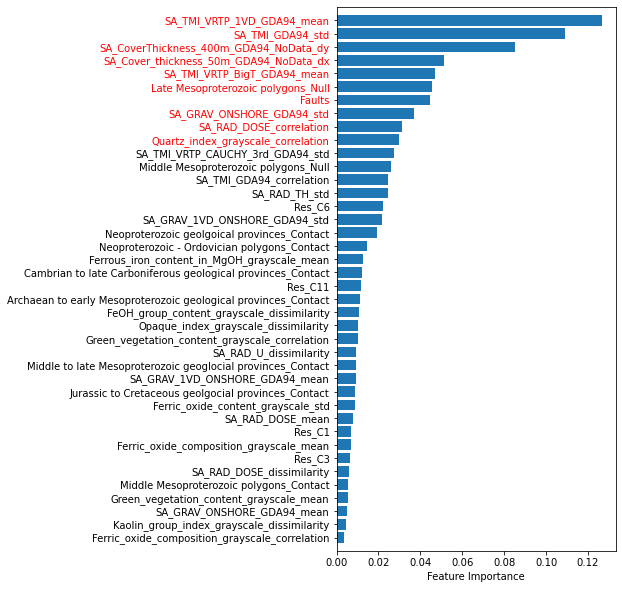

In [325]:
importances = rf_random_best.feature_importances_
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(X.columns, importances)]
feature_importances = sorted(feature_importances, key=lambda x:x[1], reverse=True)

# print significant features above some threshold
feature_importances.sort(key=lambda x:x[1])
feature_importances_plot = feature_importances[-40:]

fig, ax = plt.subplots(figsize=(5, 10))

ft_imps = [x[1] for x in feature_importances_plot]
y_pos = np.arange(len(feature_importances_plot))
ax.barh(y_pos, ft_imps, align='center')
ax.set_ylim(-1, len(ft_imps))
ax.set_yticks(range(len(ft_imps)))
ax.set_yticklabels([x[0] for x in feature_importances_plot])

# highlight top 10 features
for i in range(len(ft_imps)-10, len(ft_imps)):
    ax.get_yticklabels()[i].set_color('red')

ax.set_xlabel('Feature Importance')

plt.show()

## PU Bagging

In [326]:
# create the parameter grid based on the results of the random search
pu_param_grid = {
    'base_estimator__bootstrap': [True],
    'base_estimator__max_depth': [5, 10],
    'base_estimator__max_features': ['sqrt'],
    'base_estimator__min_samples_leaf': [2, 5],
    'base_estimator__min_samples_split': [2, 5],
    'base_estimator__n_estimators': [10, 20, 50]
}

In [327]:
#Create the positive unlabelled classifier
bc = BaggingPuClassifier(rf, n_estimators = 50, max_samples = 1000, n_jobs = -1)

#Perform gridsearch on training set and get best models training/test scores
pu_gridsearch = GridSearchCV(bc, param_grid=pu_param_grid, cv=3, scoring ='roc_auc')

# fit the random search model
pu_gridsearch.fit(X_tr.values, Y_tr.values)

GridSearchCV(cv=3,
             estimator=BaggingPuClassifier(base_estimator=RandomForestClassifier(),
                                           max_samples=1000, n_estimators=50,
                                           n_jobs=-1),
             param_grid={'base_estimator__bootstrap': [True],
                         'base_estimator__max_depth': [5, 10],
                         'base_estimator__max_features': ['sqrt'],
                         'base_estimator__min_samples_leaf': [2, 5],
                         'base_estimator__min_samples_split': [2, 5],
                         'base_estimator__n_estimators': [10, 20, 50]},
             scoring='roc_auc')

In [328]:
# best set of hyperparameters
pu_gridsearch.best_params_

{'base_estimator__bootstrap': True,
 'base_estimator__max_depth': 5,
 'base_estimator__max_features': 'sqrt',
 'base_estimator__min_samples_leaf': 2,
 'base_estimator__min_samples_split': 2,
 'base_estimator__n_estimators': 50}

In [329]:
# run the Random Forest classifier using the best set of hyperparameters
pu_grid_best = rf_gridsearch.best_estimator_
pu_grid_best.fit(X_tr, Y_tr)

train_score = pu_grid_best.score(X_tr, Y_tr)
test_score = pu_grid_best.score(X_te, Y_te)

print(train_score, test_score)

0.9987088444157521 0.9993544222078761


In [330]:
print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(Y_te, pu_grid_best.predict(X_te)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(Y_te, pu_grid_best.predict(X_te)))
print('Recall: ', recall_score(Y_te, pu_grid_best.predict(X_te)))
print('Accuracy: ', accuracy_score(Y_te, pu_grid_best.predict(X_te)))
print('F1 score: ', f1_score(Y_te, pu_grid_best.predict(X_te)))
print('ROC AUC score: ', roc_auc_score(Y_te, pu_grid_best.predict(X_te)))

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        783.0          0.0 
           true_positive          1.0        765.0 
None

Precision:  1.0
Recall:  0.9986945169712794
Accuracy:  0.9993544222078761
F1 score:  0.9993468321358588
ROC AUC score:  0.9993472584856398


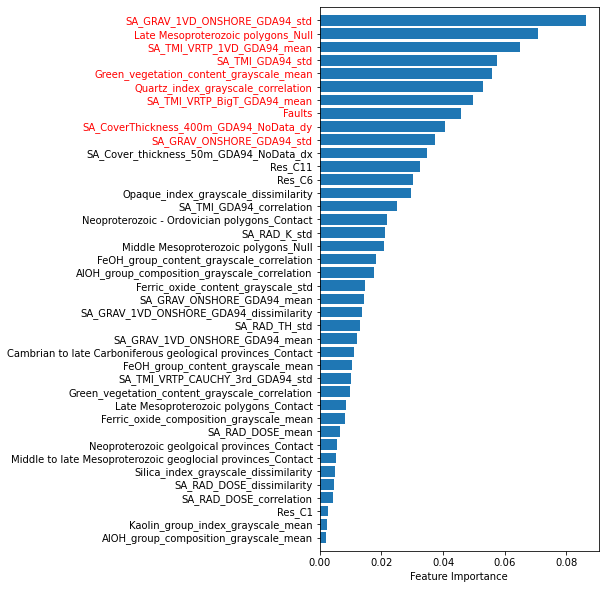

In [331]:
importances = pu_grid_best.feature_importances_
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(X.columns, importances)]
feature_importances = sorted(feature_importances, key=lambda x:x[1], reverse=True)

# print significant features above some threshold
feature_importances.sort(key=lambda x:x[1])
feature_importances_plot = feature_importances[-40:]

fig, ax = plt.subplots(figsize=(5, 10))

ft_imps = [x[1] for x in feature_importances_plot]
y_pos = np.arange(len(feature_importances_plot))
ax.barh(y_pos, ft_imps, align='center')
ax.set_ylim(-1, len(ft_imps))
ax.set_yticks(range(len(ft_imps)))
ax.set_yticklabels([x[0] for x in feature_importances_plot])

# highlight top 10 features
for i in range(len(ft_imps)-10, len(ft_imps)):
    ax.get_yticklabels()[i].set_color('red')

ax.set_xlabel('Feature Importance')

plt.show()

In [332]:
plot_3D_scatter(df, df.columns, colorby=df['label'])

interactive(children=(Dropdown(description='x', options=('SA_TMI_GDA94_mean', 'SA_TMI_GDA94_std', 'SA_TMI_GDA9…